In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
df = pd.read_csv("data_mlp.csv")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sample  200 non-null    int64  
 1   x1      200 non-null    float64
 2   x2      200 non-null    float64
 3   x3      200 non-null    float64
 4   d       200 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 7.9 KB


In [7]:
df.describe()

,Sample,x1,x2,x3,d
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,0.500101,0.491556,0.482272,0.624440
std,57.879185,0.306622,0.303002,0.284523,0.180872
min,1.000000,0.000000,0.000000,0.000000,0.085100
25%,50.750000,0.240325,0.209325,0.252475,0.492900
50%,100.500000,0.472850,0.532300,0.462600,0.627250
75%,150.250000,0.786375,0.757075,0.697900,0.771275
max,200.000000,1.000000,1.000000,1.000000,0.990400


In [8]:
X = df[['x1','x2','x3']].to_numpy().astype(float)
y = df[['d']].to_numpy().astype(float)      # shape (N,1)

In [9]:
# split 80/20
rng = np.random.default_rng(42)#  utilizando una permutación aleatoria para asegurar una división aleatoria y reproducible (gracias a la semilla seed=42)
idx = rng.permutation(len(X)); n_tr = int(0.8*len(X))
tr, va = idx[:n_tr], idx[n_tr:]
Xtr, Xva = X[tr], X[va]; ytr, yva = y[tr], y[va]

In [10]:
# escalar X con estadísticas del train
# dividir train/val como antes...
# centra los datos de entrenamiento y validación restando la media del conjunto de entrenamiento. Esto es una práctica común para normalizar los datos antes de alimentar una red neuronal.
muX = Xtr.mean(axis=0)
Xtr_c = Xtr - muX
Xva_c = Xva - muX

In [11]:
# -------- utilidades --------
def relu(z): return np.maximum(0,z)
def relu_d(z): return (z>0).astype(z.dtype)
def mse(yhat,y): return np.mean((yhat-y)**2)
def mae(yhat,y): return np.mean(np.abs(yhat-y))

In [12]:
# -------- inicialización He --------
#d_in, d_h, d_out = 3, 16, 1
#W1 = rng.normal(0, np.sqrt(2/d_in), (d_in,d_h)); b1 = np.zeros(d_h)
#W2 = rng.normal(0, np.sqrt(2/d_h), (d_h,d_out)); b2 = np.zeros(d_out)
#Inicialización
#se encarga de la inicialización de los pesos (W) y sesgos (b) para la red neuronal.
#Utiliza la inicialización de He, que es adecuada para capas con función de activación ReLU.
#Aquí se definen las dimensiones de las capas de entrada (d_in), las capas ocultas (d_h1, d_h2) y la capa de salida (d_out)
d_in, d_h1, d_h2, d_out = 3, 32, 16, 1
W1 = rng.normal(0, np.sqrt(2/d_in),  (d_in,d_h1));  b1 = np.zeros(d_h1)
W2 = rng.normal(0, np.sqrt(2/d_h1), (d_h1,d_h2));  b2 = np.zeros(d_h2)
W3 = rng.normal(0, np.sqrt(2/d_h2), (d_h2,d_out)); b3 = np.zeros(d_out)

In [13]:
# -------- entrenamiento --------
# Esta función implementa el proceso de entrenamiento de la red neuronal multicapa. Incluye:
def train_mlp(Xtr_c, ytr, Xva_c, yva, *,
              d_h1=32, d_h2=16, lr=3e-4, l2=1e-5,
              epochs=2000, batch=32, seed=42):
    rng = np.random.default_rng(seed)

    # init He (ReLU)
    d_in, d_out = Xtr_c.shape[1], 1
    W1 = rng.normal(0, np.sqrt(2/d_in),  (d_in, d_h1)); b1 = np.zeros(d_h1)
    W2 = rng.normal(0, np.sqrt(2/d_h1), (d_h1, d_h2)); b2 = np.zeros(d_h2)
    W3 = rng.normal(0, np.sqrt(2/d_h2), (d_h2, d_out)); b3 = np.zeros(d_out)

    N = len(Xtr_c)
    def relu(z): return np.maximum(0, z)
    def mse(yh,y): return np.mean((yh-y)**2)

    for ep in range(epochs):
        # mini-batch
        for s in range(0, N, batch):
            xb, yb = Xtr_c[s:s+batch], ytr[s:s+batch]

            z1 = xb @ W1 + b1; h1 = relu(z1)
            z2 = h1 @ W2 + b2; h2 = relu(z2)
            yhat = h2 @ W3 + b3

            dY  = (yhat - yb)/len(xb)
            gW3 = h2.T @ dY + (2*l2/N)*W3; gb3 = dY.sum(0)

            dh2 = dY @ W3.T
            dz2 = dh2 * (z2 > 0)
            gW2 = h1.T @ dz2 + (2*l2/N)*W2; gb2 = dz2.sum(0)

            dh1 = dz2 @ W2.T
            dz1 = dh1 * (z1 > 0)
            gW1 = xb.T @ dz1 + (2*l2/N)*W1; gb1 = dz1.sum(0)

            W3 -= lr*gW3; b3 -= lr*gb3
            W2 -= lr*gW2; b2 -= lr*gb2
            W1 -= lr*gW1; b1 -= lr*gb1

        # simple LR decay opcional
        if (ep+1) % 500 == 0:
            lr *= 0.5

    # métrica final
    def predict(Xc):#  para realizar predicciones y calcula el error cuadrático medio (MSE) en el conjunto de validación.
        return relu(relu(Xc@W1+b1)@W2+b2)@W3+b3

    yva_hat = predict(Xva_c)
    return mse(yva_hat, yva)

In [15]:
# -------- predicción --------
# para probar diferentes tasas de aprendizaje (lr) definidas en grid_lr. Entrena el modelo con cada tasa de aprendizaje y
# muestra el MSE en el conjunto de validación para cada una. Esto ayuda a encontrar una tasa de aprendizaje adecuada para el entrenamiento.
grid_lr = [1e-4, 3e-4, 5e-4, 1e-3]
for lr in grid_lr:#con parametros ideales
    m = train_mlp(Xtr_c, ytr, Xva_c, yva, lr=lr, l2=1e-5, d_h1=32, d_h2=16, epochs=2000)
    print(f"lr={lr:.0e} -> MSE_va={m:.6f}")

lr=1e-04 -> MSE_va=0.127343
lr=3e-04 -> MSE_va=0.035686
lr=5e-04 -> MSE_va=0.019162
lr=1e-03 -> MSE_va=0.006552


In [16]:
'''
 realiza una búsqueda similar, pero esta vez varía el parámetro de regularización L2 (l2) utilizando los valores definidos en grid_l2.
 Entrena el modelo con cada valor de l2 (manteniendo el mejor lr encontrado anteriormente) y muestra el MSE en el conjunto de validación.
 Esto ayuda a determinar si la regularización L2 mejora el rendimiento del modelo y cuál es un buen valor para ella.
'''
grid_l2 = [0.0, 1e-6, 1e-5, 1e-4]
for l2 in grid_l2:
    m = train_mlp(Xtr_c, ytr, Xva_c, yva, lr=3e-4, l2=l2, d_h1=32, d_h2=16, epochs=2000)
    print(f"l2={l2:.0e} -> MSE_va={m:.6f}")

l2=0e+00 -> MSE_va=0.035686
l2=1e-06 -> MSE_va=0.035686
l2=1e-05 -> MSE_va=0.035686
l2=1e-04 -> MSE_va=0.035686


In [17]:
grid_lr = [1e-4, 2e-4, 3e-4, 5e-4, 7e-4, 1e-3]
res = []
for lr in grid_lr:
    m = train_mlp(Xtr_c, ytr, Xva_c, yva, lr=lr, l2=1e-5, d_h1=32, d_h2=16, epochs=2000, seed=42)
    res.append((lr, m))
    print(f"lr={lr:.0e} -> MSE_va={m:.6f}")

res_sorted = sorted(res, key=lambda t: t[1])
print("Top-2:", res_sorted[:2])

lr=1e-04 -> MSE_va=0.127343
lr=2e-04 -> MSE_va=0.054101
lr=3e-04 -> MSE_va=0.035686
lr=5e-04 -> MSE_va=0.019162
lr=7e-04 -> MSE_va=0.011428
lr=1e-03 -> MSE_va=0.006552
Top-2: [(0.001, np.float64(0.006551554451019512)), (0.0007, np.float64(0.011427968066771623))]


In [18]:
grid_l2 = [0.0, 1e-6, 1e-5, 5e-5, 1e-4]
for l2 in grid_l2:
    m = train_mlp(Xtr_c, ytr, Xva_c, yva,
                  lr=1e-3, l2=l2, d_h1=32, d_h2=16,
                  epochs=2000, seed=42)
    print(f"l2={l2:.0e} -> MSE_va={m:.6f}")

l2=0e+00 -> MSE_va=0.006552
l2=1e-06 -> MSE_va=0.006552
l2=1e-05 -> MSE_va=0.006552
l2=5e-05 -> MSE_va=0.006552
l2=1e-04 -> MSE_va=0.006552


In [19]:
# experimenta con diferentes tamaños para las capas ocultas (d_h1 y d_h2) para ver cómo afectan el rendimiento del modelo.
for h in [8, 16, 32, 64]:
    m = train_mlp(Xtr_c, ytr, Xva_c, yva,
                  lr=1e-3, l2=0, d_h1=h, d_h2=h//2,
                  epochs=2000, seed=42)
    print(f"d_h1={h}, d_h2={h//2} -> MSE_va={m:.6f}")

d_h1=8, d_h2=4 -> MSE_va=0.009964
d_h1=16, d_h2=8 -> MSE_va=0.008415
d_h1=32, d_h2=16 -> MSE_va=0.006552
d_h1=64, d_h2=32 -> MSE_va=0.011649


In [20]:
# Nueva función predict
# define una nueva función predict que utiliza los pesos y sesgos ya entrenados para realizar predicciones en nuevos datos de entrada.
def predict(Xnew):
    return relu(relu(Xnew@W1+b1)@W2+b2)@W3+b3

MAE_tr: 0.3332419017479641 MAE_va: 0.27741459709501787


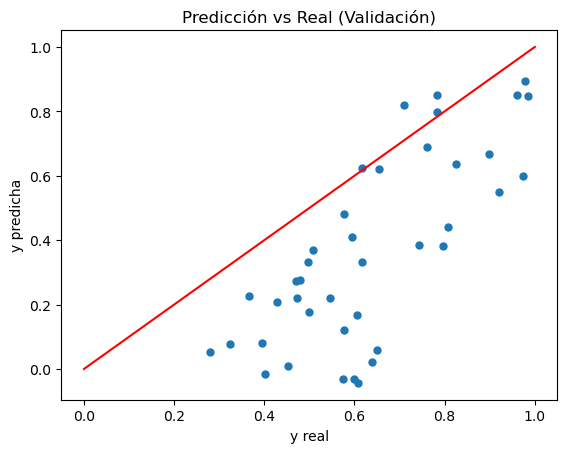

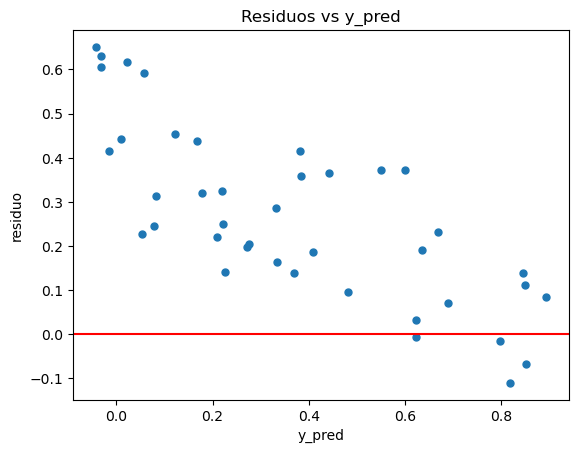

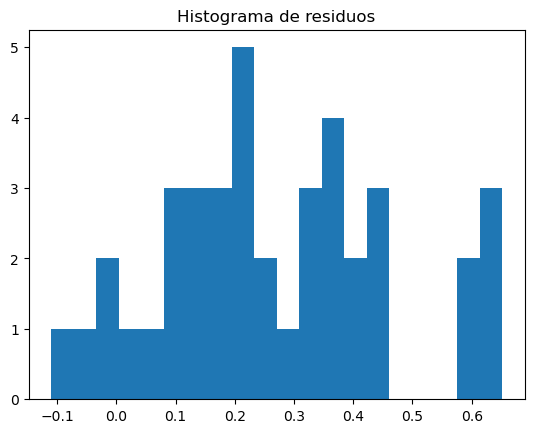

In [21]:
#  Forward final
'''
utiliza la función predict para obtener las predicciones en los conjuntos de entrenamiento y validación.
Luego, calcula y muestra el Error Absoluto Medio (MAE) para ambos conjuntos.
Finalmente, genera tres gráficos para visualizar el rendimiento del modelo:
'''
ytr_hat = predict(Xtr).reshape(-1)
yva_hat = predict(Xva).reshape(-1)
ytr_1d = ytr.reshape(-1)
yva_1d = yva.reshape(-1)

print("MAE_tr:", mae(ytr_hat, ytr_1d), "MAE_va:", mae(yva_hat, yva_1d))

# 1) y vs y_hat
plt.scatter(yva_1d, yva_hat, s=25)
plt.xlabel("y real"); plt.ylabel("y predicha")
plt.title("Predicción vs Real (Validación)")
plt.plot([0,1],[0,1],'r')
plt.show()

# 2) residuos
res = yva_1d - yva_hat
plt.scatter(yva_hat, res, s=25)
plt.xlabel("y_pred"); plt.ylabel("residuo")
plt.title("Residuos vs y_pred")
plt.axhline(0, color='r'); plt.show()

# 3) histograma
plt.hist(res, bins=20); plt.title("Histograma de residuos"); plt.show()


MAE_va: 0.548040945995855
R2_va: -8.563350735071074


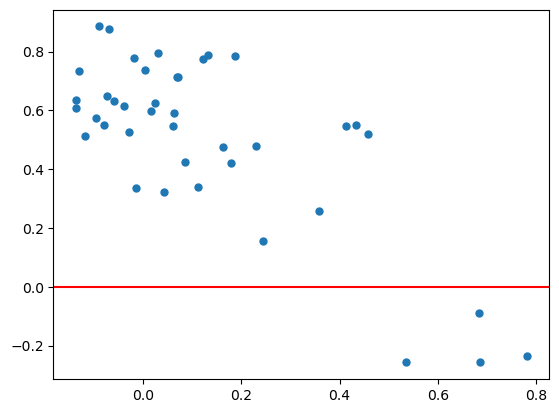

In [22]:
# métricas
'''
calcula y muestra métricas adicionales para evaluar el rendimiento del modelo en el conjunto de validación,
incluyendo el Error Absoluto Medio (MAE) y el coeficiente de determinación R2.
También genera un gráfico de dispersión de los residuos vs. los valores predichos en el conjunto de validación.
'''

from sklearn.metrics import r2_score
yva_hat = predict(Xva_c)
print("MAE_va:", np.mean(np.abs(yva_hat - yva)))
print("R2_va:", r2_score(yva, yva_hat))

# residuos
res = (yva - yva_hat).reshape(-1)
plt.scatter(yva_hat.reshape(-1), res, s=25); plt.axhline(0, color='r'); plt.show()

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
'''
entrena un modelo de regresión lineal utilizando los mismos datos centrados que se usaron para entrenar la red neuronal.
Esto se hace para comparar el rendimiento de la red neuronal con un modelo lineal más simple.
Luego, calcula y muestra las métricas de evaluación (MSE, MAE, R2) para el modelo de regresión lineal en los conjuntos de entrenamiento y validación.
'''

# Entrenar modelo lineal con los mismos datos centrados
lin = LinearRegression()
lin.fit(Xtr_c, ytr)

# Predicción y métricas
yva_hat_lin = lin.predict(Xva_c)
ytr_hat_lin = lin.predict(Xtr_c)

print("Regresión Lineal:")
print(" MSE_tr:", mean_squared_error(ytr, ytr_hat_lin))
print(" MSE_va:", mean_squared_error(yva, yva_hat_lin))
print(" MAE_va:", mean_absolute_error(yva, yva_hat_lin))
print(" R2_va:", r2_score(yva, yva_hat_lin))

Regresión Lineal:
 MSE_tr: 0.0012989739087463903
 MSE_va: 0.001560291634440074
 MAE_va: 0.033436441182880486
 R2_va: 0.9560638146815473


In [24]:
'''
 muestra los coeficientes y el intercepto del modelo de regresión lineal entrenado en la celda anterior.
 Esto permite ver la relación lineal que el modelo ha encontrado entre las características y la variable objetivo.
'''
print("Coeficientes:", lin.coef_)
print("Intercepto:", lin.intercept_)

Coeficientes: [[0.35086875 0.35268554 0.34587054]]
Intercepto: [0.62211937]


In [25]:
'''
define una nueva función llamada train_mlp_track. Esta función es similar a train_mlp,
pero con la diferencia de que registra las pérdidas (MSE) en los conjuntos de entrenamiento y validación cada 50 épocas.
Esto es útil para visualizar las curvas de aprendizaje.
'''
def train_mlp_track(Xtr_c, ytr, Xva_c, yva, *,
                    d_h1=32, d_h2=16, lr=1e-3, l2=0,
                    epochs=2000, batch=32, seed=42):
    rng = np.random.default_rng(seed)
    d_in, d_out = Xtr_c.shape[1], 1
    W1 = rng.normal(0, np.sqrt(2/d_in),  (d_in,d_h1)); b1 = np.zeros(d_h1)
    W2 = rng.normal(0, np.sqrt(2/d_h1), (d_h1,d_h2));  b2 = np.zeros(d_h2)
    W3 = rng.normal(0, np.sqrt(2/d_h2), (d_h2,d_out)); b3 = np.zeros(d_out)

    def relu(z): return np.maximum(0,z)
    def mse(yh,y): return np.mean((yh-y)**2)
    N = len(Xtr_c)

    hist_tr, hist_va = [], []

    for ep in range(epochs):
        for s in range(0, N, batch):
            xb, yb = Xtr_c[s:s+batch], ytr[s:s+batch]

            z1 = xb @ W1 + b1; h1 = relu(z1)
            z2 = h1 @ W2 + b2; h2 = relu(z2)
            yhat = h2 @ W3 + b3

            dY  = (yhat - yb)/len(xb)
            gW3 = h2.T @ dY + (2*l2/N)*W3; gb3 = dY.sum(0)
            dh2 = dY @ W3.T; dz2 = dh2 * (z2>0)
            gW2 = h1.T @ dz2 + (2*l2/N)*W2; gb2 = dz2.sum(0)
            dh1 = dz2 @ W2.T; dz1 = dh1 * (z1>0)
            gW1 = xb.T @ dz1 + (2*l2/N)*W1; gb1 = dz1.sum(0)

            W3 -= lr*gW3; b3 -= lr*gb3
            W2 -= lr*gW2; b2 -= lr*gb2
            W1 -= lr*gW1; b1 -= lr*gb1

        # registrar pérdida cada 50 épocas
        if (ep+1) % 50 == 0:
            def fwd(Xc): return relu(relu(Xc@W1+b1)@W2+b2)@W3+b3
            hist_tr.append(mse(fwd(Xtr_c), ytr))
            hist_va.append(mse(fwd(Xva_c), yva))

    return hist_tr, hist_va


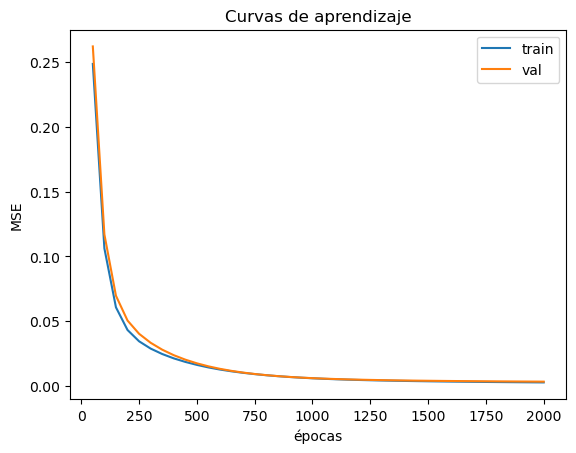

In [26]:
#para graficar las curvas de aprendizaje (pérdida vs. épocas) para los conjuntos de entrenamiento y validación.
#Estas curvas ayudan a diagnosticar si el modelo está sobreajustando o subajustando.
hist_tr, hist_va = train_mlp_track(Xtr_c, ytr, Xva_c, yva)

plt.plot(range(50,2001,50), hist_tr, label="train")
plt.plot(range(50,2001,50), hist_va, label="val")
plt.xlabel("épocas"); plt.ylabel("MSE")
plt.title("Curvas de aprendizaje")
plt.legend(); plt.show()

In [27]:
# Cambiar tasa de aprendizaje
#hist_tr, hist_va = train_mlp_track(Xtr_c,ytr,Xva_c,yva, lr=7e-4)

# Cambiar capacidad
#hist_tr, hist_va = train_mlp_track(Xtr_c,ytr,Xva_c,yva, d_h1=48, d_h2=24)

# Regularización y batch
#hist_tr, hist_va = train_mlp_track(Xtr_c,ytr,Xva_c,yva, l2=1e-5, batch=64)

# Más épocas y semilla fija para reproducibilidad
#hist_tr, hist_va = train_mlp_track(Xtr_c,ytr,Xva_c,yva, epochs=3000, seed=7)

Modificar la función `train_mlp_track` para incluir la opción de usar la función de activación sigmoide, implementar una condición de parada basada en la precisión y devolver el MSE final y el número total de épocas.



Llamar a la función `train_mlp_track` cinco veces con la función de activación sigmoide, una tasa de aprendizaje η=0.1 y una precisión ε=10⁻⁶.


In [28]:
def train_mlp_track(Xtr_c, ytr, Xva_c, yva, *,
                    d_h1=32, d_h2=16, lr=1e-3, l2=0,
                    epochs=2000, batch=32, seed=42,
                    activation='relu', tol=1e-6):

    rng = np.random.default_rng(seed)
    d_in, d_out = Xtr_c.shape[1], 1
    W1 = rng.normal(0, np.sqrt(2/d_in),  (d_in,d_h1)); b1 = np.zeros(d_h1)
    W2 = rng.normal(0, np.sqrt(2/d_h1), (d_h1,d_h2));  b2 = np.zeros(d_h2)
    W3 = rng.normal(0, np.sqrt(2/d_h2), (d_h2,d_out)); b3 = np.zeros(d_out)

    def sigmoid(z): return 1/(1 + np.exp(-z))
    def sigmoid_d(z): return sigmoid(z) * (1 - sigmoid(z))
    def relu(z): return np.maximum(0,z)
    def relu_d(z): return (z>0).astype(z.dtype)
    def mse(yh,y): return np.mean((yh-y)**2)
    N = len(Xtr_c)

    prev_va_mse = float('inf')

    for ep in range(epochs):
        for s in range(0, N, batch):
            xb, yb = Xtr_c[s:s+batch], ytr[s:s+batch]

            # Forward pass
            z1 = xb @ W1 + b1
            h1 = relu(z1) if activation == 'relu' else sigmoid(z1)
            z2 = h1 @ W2 + b2
            h2 = relu(z2) if activation == 'relu' else sigmoid(z2)
            yhat = h2 @ W3 + b3

            # Backward pass
            dY  = (yhat - yb)/len(xb)
            gW3 = h2.T @ dY + (2*l2/N)*W3; gb3 = dY.sum(0)

            dh2 = dY @ W3.T
            dz2 = dh2 * (relu_d(z2) if activation == 'relu' else sigmoid_d(z2))
            gW2 = h1.T @ dz2 + (2*l2/N)*W2; gb2 = dz2.sum(0)

            dh1 = dz2 @ W2.T
            dz1 = dh1 * (relu_d(z1) if activation == 'relu' else sigmoid_d(z1))
            gW1 = xb.T @ dz1 + (2*l2/N)*W1; gb1 = dz1.sum(0)

            W3 -= lr*gW3; b3 -= lr*gb3
            W2 -= lr*gW2; b2 -= lr*gb2
            W1 -= lr*gW1; b1 -= lr*gb1

        # Calculate validation MSE and check stopping condition
        def fwd(Xc):
            h1_fwd = relu(Xc@W1+b1) if activation == 'relu' else sigmoid(Xc@W1+b1)
            h2_fwd = relu(h1_fwd@W2+b2) if activation == 'relu' else sigmoid(h1_fwd@W2+b2)
            return h2_fwd@W3+b3

        va_mse = mse(fwd(Xva_c), yva)

        if abs(prev_va_mse - va_mse) < tol:
            break
        prev_va_mse = va_mse

    return va_mse, ep + 1

results = []
for i in range(5):
    va_mse, epochs = train_mlp_track(Xtr_c, ytr, Xva_c, yva,#aqui se ejecuta el punto 1 con los parametros que da el ejercicio
                                     activation='sigmoid',
                                     lr=0.1,
                                     tol=1e-6,
                                     seed=42 + i)
    results.append({'MSE': va_mse, 'Epochs': epochs})


Crear un nuevo DataFrame para almacenar los resultados (MSE final y número de épocas) obtenidos de las cinco ejecuciones de `train_mlp_track` y poblarlo con los datos almacenados en la lista `results`.


In [31]:
results_df = pd.DataFrame(results)# para el punto 2
display(results_df)#interpretar resultados y explicar para punto 4

,MSE,Epochs
0,0.001312,361
1,0.001336,199
2,0.001349,329
3,0.001400,183
4,0.001226,219


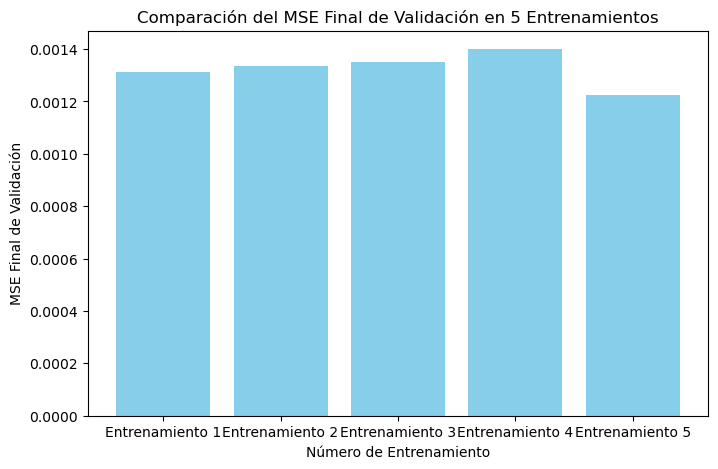

In [32]:
import matplotlib.pyplot as plt

# Extraer los MSE del DataFrame
mse_values = results_df['MSE']

# Crear un gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(range(len(mse_values)), mse_values, color='skyblue')
plt.xlabel('Número de Entrenamiento')
plt.ylabel('MSE Final de Validación')
plt.title('Comparación del MSE Final de Validación en 5 Entrenamientos')
plt.xticks(range(len(mse_values)), [f'Entrenamiento {i+1}' for i in range(len(mse_values))])
plt.show()

Modifica la función `train_mlp_track` para que devuelva el historial del MSE de entrenamiento y validación en cada época (o cada cierto número de épocas). Luego, llama a esta función 5 veces con los parámetros: función de activación sigmoidea, tasa de aprendizaje η=0.1 y precisión ε=10⁻⁶. Finalmente, crea un único gráfico que muestre las curvas de aprendizaje (MSE vs épocas) para cada una de las 5 ejecuciones, incluyendo etiquetas, título y leyenda.


Modificar la función `train_mlp_track` para incluir la opción de usar la función de activación sigmoide, implementar una condición de parada basada en la precisión y devolver el MSE final y el número total de épocas.


In [33]:
def train_mlp_track(Xtr_c, ytr, Xva_c, yva, *,
                    d_h1=32, d_h2=16, lr=1e-3, l2=0,
                    epochs=2000, batch=32, seed=42,
                    activation='relu', tol=1e-6):

    rng = np.random.default_rng(seed)
    d_in, d_out = Xtr_c.shape[1], 1
    W1 = rng.normal(0, np.sqrt(2/d_in),  (d_in,d_h1)); b1 = np.zeros(d_h1)
    W2 = rng.normal(0, np.sqrt(2/d_h1), (d_h1,d_h2));  b2 = np.zeros(d_h2)
    W3 = rng.normal(0, np.sqrt(2/d_h2), (d_h2,d_out)); b3 = np.zeros(d_out)

    def sigmoid(z): return 1/(1 + np.exp(-z))
    def sigmoid_d(z): return sigmoid(z) * (1 - sigmoid(z))
    def relu(z): return np.maximum(0,z)
    def relu_d(z): return (z>0).astype(z.dtype)
    def mse(yh,y): return np.mean((yh-y)**2)
    N = len(Xtr_c)

    prev_va_mse = float('inf')

    for ep in range(epochs):
        for s in range(0, N, batch):
            xb, yb = Xtr_c[s:s+batch], ytr[s:s+batch]

            # Forward pass
            z1 = xb @ W1 + b1
            h1 = relu(z1) if activation == 'relu' else sigmoid(z1)
            z2 = h1 @ W2 + b2
            h2 = relu(z2) if activation == 'relu' else sigmoid(z2)
            yhat = h2 @ W3 + b3

            # Backward pass
            dY  = (yhat - yb)/len(xb)
            gW3 = h2.T @ dY + (2*l2/N)*W3; gb3 = dY.sum(0)

            dh2 = dY @ W3.T
            dz2 = dh2 * (relu_d(z2) if activation == 'relu' else sigmoid_d(z2))
            gW2 = h1.T @ dz2 + (2*l2/N)*W2; gb2 = dz2.sum(0)

            dh1 = dz2 @ W2.T
            dz1 = dh1 * (relu_d(z1) if activation == 'relu' else sigmoid_d(z1))
            gW1 = xb.T @ dz1 + (2*l2/N)*W1; gb1 = dz1.sum(0)

            W3 -= lr*gW3; b3 -= lr*gb3
            W2 -= lr*gW2; b2 -= lr*gb2
            W1 -= lr*gW1; b1 -= lr*gb1

        # Calculate validation MSE and check stopping condition
        def fwd(Xc):
            h1_fwd = relu(Xc@W1+b1) if activation == 'relu' else sigmoid(Xc@W1+b1)
            h2_fwd = relu(h1_fwd@W2+b2) if activation == 'relu' else sigmoid(h1_fwd@W2+b2)
            return h2_fwd@W3+b3

        va_mse = mse(fwd(Xva_c), yva)

        if abs(prev_va_mse - va_mse) < tol:
            break
        prev_va_mse = va_mse

    return va_mse, ep + 1


Llamar a la función `train_mlp_track` cinco veces con la función de activación sigmoide, una tasa de aprendizaje η=0.1 y una precisión ε=10⁻⁶.


In [54]:
# ...existing code...
all_histories = []
for i in range(5):
    out = train_mlp_track(Xtr_c, ytr, Xva_c, yva,
                         activation='sigmoid',
                         lr=0.1,
                         tol=1e-6,
                         seed=42 + i,
                         epochs=5000)

    # Si la función devuelve (hist_tr, hist_va, ...) (esperado)
    if isinstance(out, tuple) and len(out) >= 2 and hasattr(out[0], "__len__"):
        hist_tr, hist_va = out[0], out[1]
    else:
        # Firma inesperada: informar y salir para evitar errores posteriores
        raise RuntimeError("train_mlp_track devolvió una firma inesperada. Asegúrate de ejecutar la definición que devuelve (hist_tr, hist_va, ...).")

    all_histories.append((np.asarray(hist_tr), np.asarray(hist_va)))




Crear un único gráfico que muestre las curvas de aprendizaje (MSE vs épocas) para cada una de las 5 ejecuciones, incluyendo etiquetas, título y leyenda.


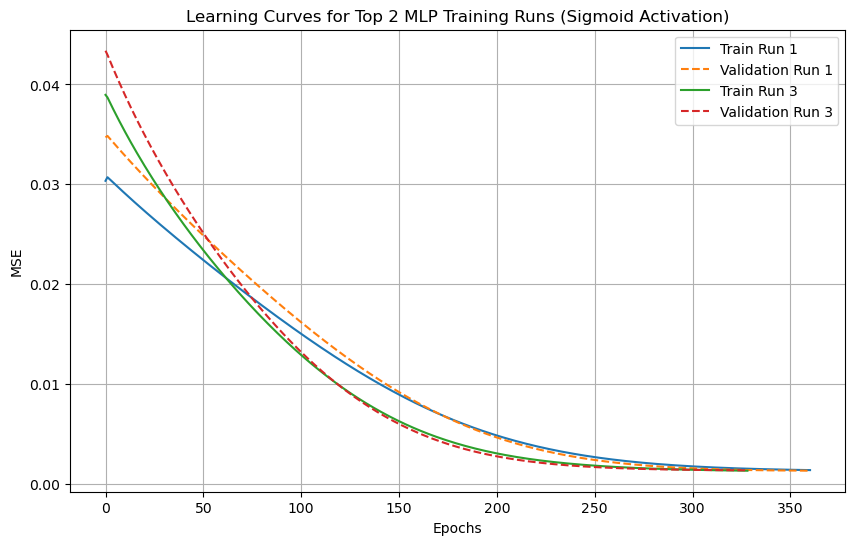

In [55]:
# Encontrar los índices de los dos entrenamientos con más épocas
epoch_counts = [len(hist_tr) for hist_tr, hist_va in all_histories]
sorted_indices = sorted(range(len(epoch_counts)), key=lambda k: epoch_counts[k], reverse=True)
top_2_indices = sorted_indices[:2]

plt.figure(figsize=(10, 6))
for i in top_2_indices:#para el punto 3
    hist_tr, hist_va = all_histories[i]
    epochs = range(len(hist_tr))
    plt.plot(epochs, hist_tr, label=f"Train Run {i+1}")
    plt.plot(epochs, hist_va, label=f"Validation Run {i+1}", linestyle='--')

plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Learning Curves for Top 2 MLP Training Runs (Sigmoid Activation)")
plt.legend()
plt.grid(True)
plt.show()

In [37]:
df_val = pd.read_csv("validacion.csv")

In [38]:
X_val = df_val[['x1','x2','x3']].to_numpy().astype(float)
y_val = df_val[['d']].to_numpy().astype(float)
X_val_c = X_val - muX

In [39]:
y_val_hat = predict(X_val_c).reshape(-1)# para punto 5

In [40]:
y_val_1d = y_val.reshape(-1)
relative_error = np.abs(y_val_1d - y_val_hat) / y_val_1d
mre = np.mean(relative_error)

In [41]:
print("Error Relativo Medio (MRE):", mre)# jamas esperen un error cuadratico menor utilizando una funcion de activacion sigmoidea en un problema de regresion, esta funcion esta hecha para problemas de clasificacion binaria

Error Relativo Medio (MRE): 0.8660931201438382


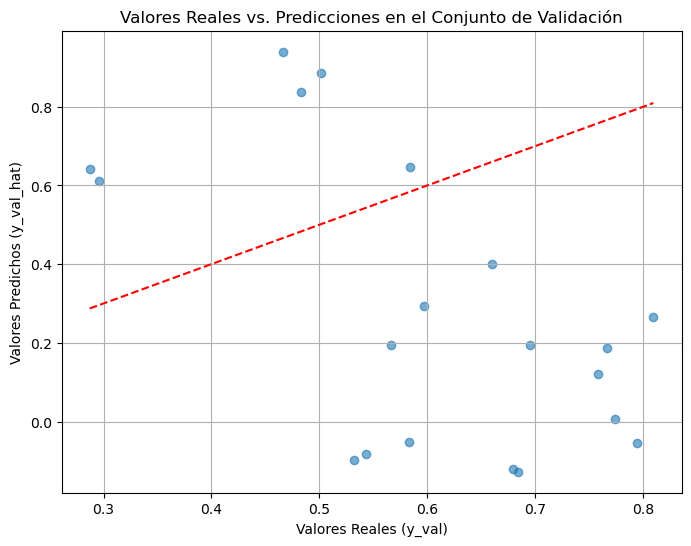

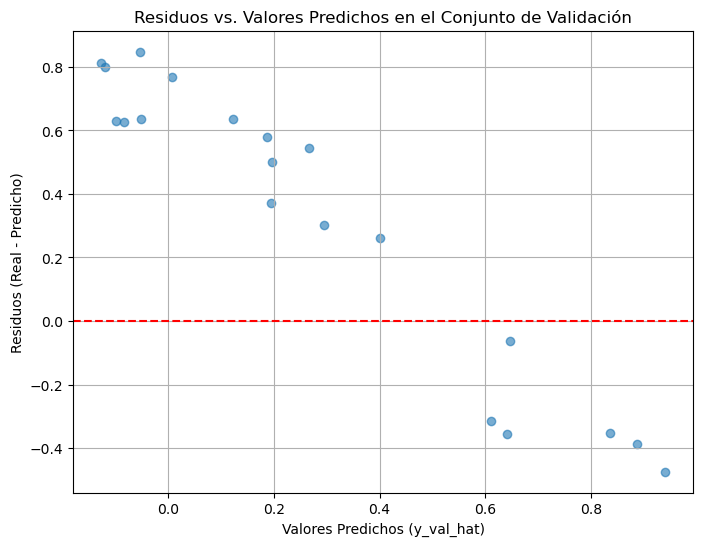

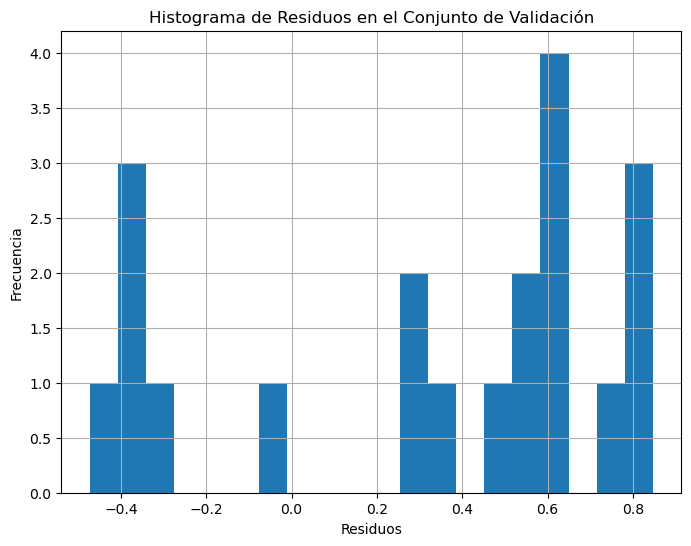

In [42]:
import matplotlib.pyplot as plt

# Gráfico de dispersión de valores reales vs. predichos en validación
plt.figure(figsize=(8, 6))
plt.scatter(y_val_1d, y_val_hat, alpha=0.6) # Usamos y_val_1d que ya está aplanado
plt.xlabel("Valores Reales (y_val)")
plt.ylabel("Valores Predichos (y_val_hat)")
plt.title("Valores Reales vs. Predicciones en el Conjunto de Validación")
plt.plot([y_val_1d.min(), y_val_1d.max()], [y_val_1d.min(), y_val_1d.max()], 'r--') # Línea y=x de referencia
plt.grid(True)
plt.show()

# Gráfico de dispersión de residuos vs. valores predichos en validación
residuos = y_val_1d - y_val_hat
plt.figure(figsize=(8, 6))
plt.scatter(y_val_hat, residuos, alpha=0.6)
plt.xlabel("Valores Predichos (y_val_hat)")
plt.ylabel("Residuos (Real - Predicho)")
plt.title("Residuos vs. Valores Predichos en el Conjunto de Validación")
plt.axhline(0, color='r', linestyle='--') # Línea de referencia en 0
plt.grid(True)
plt.show()

# Histograma de residuos
plt.figure(figsize=(8, 6))
plt.hist(residuos, bins=20)
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.title("Histograma de Residuos en el Conjunto de Validación")
plt.grid(True)
plt.show()

In [43]:
# Agregar la columna de valores predichos al DataFrame df_val
df_val['d_predicted'] = y_val_hat

# Mostrar el DataFrame modificado
display(df_val.head())

,Samples,x1,x2,x3,d,d_predicted
0,1,0.0611,0.2860,0.7464,0.4831,0.836898
1,2,0.5102,0.7464,0.0860,0.5965,0.294137
2,3,0.0004,0.6916,0.5006,0.5318,-0.098634
3,4,0.9430,0.4476,0.2648,0.6843,-0.127220
4,5,0.1399,0.1610,0.2477,0.2872,0.641866


In [44]:
df_val.describe()

,Samples,x1,x2,x3,d,d_predicted
count,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,10.50000,0.432990,0.446075,0.536075,0.602860,0.284640
std,5.91608,0.338287,0.278634,0.280837,0.150726,0.359016
min,1.00000,0.000400,0.000700,0.086000,0.287200,-0.127220
25%,5.75000,0.171325,0.245575,0.270125,0.524150,-0.052555
50%,10.50000,0.308900,0.387000,0.571400,0.590050,0.194588
75%,15.25000,0.716150,0.662125,0.782000,0.710775,0.618071
max,20.00000,0.999100,0.934200,0.904600,0.809300,0.940042


In [45]:
y_val_hat = predict(X_val_c).reshape(-1)

Implementar la fórmula del Error Relativo Medio (MRE) y calcularlo utilizando los valores deseados (`y_val`) y las predicciones (`y_val_hat`).


In [46]:
y_val_1d = y_val.reshape(-1)
relative_error = np.abs(y_val_1d - y_val_hat) / y_val_1d
mre = np.mean(relative_error)


Mostrar el valor calculado del Error Relativo Medio (MRE).


In [47]:
print("Error Relativo Medio (MRE):", mre)

Error Relativo Medio (MRE): 0.8660931201438382


Modificar la función para que devuelva los pesos (W1, W2, W3) y sesgos (b1, b2, b3) entrenados al final de cada ejecución.

In [48]:
def train_mlp_track(Xtr_c, ytr, Xva_c, yva, *,
                    d_h1=32, d_h2=16, lr=1e-3, l2=0,
                    epochs=2000, batch=32, seed=42,
                    activation='relu', tol=1e-6):

    rng = np.random.default_rng(seed)
    d_in, d_out = Xtr_c.shape[1], 1
    W1 = rng.normal(0, np.sqrt(2/d_in),  (d_in,d_h1)); b1 = np.zeros(d_h1)
    W2 = rng.normal(0, np.sqrt(2/d_h1), (d_h1,d_h2));  b2 = np.zeros(d_h2)
    W3 = rng.normal(0, np.sqrt(2/d_h2), (d_h2,d_out)); b3 = np.zeros(d_out)

    def sigmoid(z): return 1/(1 + np.exp(-z))
    def sigmoid_d(z): return sigmoid(z) * (1 - sigmoid(z))
    def relu(z): return np.maximum(0,z)
    def relu_d(z): return (z>0).astype(z.dtype)
    def mse(yh,y): return np.mean((yh-y)**2)
    N = len(Xtr_c)

    prev_va_mse = float('inf')
    hist_tr, hist_va = [], []


    for ep in range(epochs):
        for s in range(0, N, batch):
            xb, yb = Xtr_c[s:s+batch], ytr[s:s+batch]

            # Forward pass
            z1 = xb @ W1 + b1
            h1 = relu(z1) if activation == 'relu' else sigmoid(z1)
            z2 = h1 @ W2 + b2
            h2 = relu(z2) if activation == 'relu' else sigmoid(z2)
            yhat = h2 @ W3 + b3

            # Backward pass
            dY  = (yhat - yb)/len(xb)
            gW3 = h2.T @ dY + (2*l2/N)*W3; gb3 = dY.sum(0)

            dh2 = dY @ W3.T
            dz2 = dh2 * (relu_d(z2) if activation == 'relu' else sigmoid_d(z2))
            gW2 = h1.T @ dz2 + (2*l2/N)*W2; gb2 = dz2.sum(0)

            dh1 = dz2 @ W2.T
            dz1 = dh1 * (relu_d(z1) if activation == 'relu' else sigmoid_d(z1))
            gW1 = xb.T @ dz1 + (2*l2/N)*W1; gb1 = dz1.sum(0)

            W3 -= lr*gW3; b3 -= lr*gb3
            W2 -= lr*gW2; b2 -= lr*gb2
            W1 -= lr*gW1; b1 -= lr*gb1

        # Calculate validation MSE and check stopping condition
        def fwd(Xc):
            h1_fwd = relu(Xc@W1+b1) if activation == 'relu' else sigmoid(Xc@W1+b1)
            h2_fwd = relu(h1_fwd@W2+b2) if activation == 'relu' else sigmoid(h1_fwd@W2+b2)
            return h2_fwd@W3+b3

        va_mse = mse(fwd(Xva_c), yva)
        hist_va.append(va_mse)
        hist_tr.append(mse(fwd(Xtr_c), ytr))


        if abs(prev_va_mse - va_mse) < tol:
            break
        prev_va_mse = va_mse

    return hist_tr, hist_va, W1, b1, W2, b2, W3, b3


Llamar a la función `train_mlp_track` cinco veces con los parámetros deseados y almacenar los conjuntos de pesos y sesgos devueltos por cada ejecución.


In [49]:
trained_params = []
for i in range(5):
    hist_tr, hist_va, W1, b1, W2, b2, W3, b3 = train_mlp_track(Xtr_c, ytr, Xva_c, yva,
                                                               activation='sigmoid',
                                                               lr=0.1,
                                                               tol=1e-6,
                                                               seed=42 + i,
                                                               epochs=5000)
    trained_params.append((W1, b1, W2, b2, W3, b3))


Iterar sobre los cinco conjuntos de pesos y sesgos almacenados. Para cada conjunto, usar la función `predict` (o una versión modificada que acepte pesos/sesgos como argumentos) para obtener las predicciones en `X_val_c`. Almacenar las predicciones de cada ejecución en una lista o estructura similar. Crear un DataFrame donde cada columna represente las predicciones de una de las cinco ejecuciones, y el índice sea el del DataFrame `df_val`.


In [50]:
all_predictions = []

def sigmoid(z): return 1/(1 + np.exp(-z))
def relu(z): return np.maximum(0,z)


def predict_with_params(Xc, W1, b1, W2, b2, W3, b3, activation='sigmoid'):
    z1 = Xc @ W1 + b1
    h1 = relu(z1) if activation == 'relu' else sigmoid(z1)
    z2 = h1 @ W2 + b2
    h2 = relu(z2) if activation == 'relu' else sigmoid(z2)
    yhat = h2 @ W3 + b3
    return yhat

for i, (W1, b1, W2, b2, W3, b3) in enumerate(trained_params):
    y_val_hat_run = predict_with_params(X_val_c, W1, b1, W2, b2, W3, b3, activation='sigmoid').reshape(-1)
    all_predictions.append(y_val_hat_run)

predictions_df = pd.DataFrame(all_predictions).T
predictions_df.columns = [f'Prediction_{i+1}' for i in range(len(all_predictions))]
predictions_df.index = df_val.index


Mostrar el DataFrame resultante para visualizar las predicciones de cada una de las cinco validaciones.


In [51]:
display(predictions_df)# para punto 6

,Prediction_1,Prediction_2,Prediction_3,Prediction_4,Prediction_5
0,0.491190,0.508123,0.502928,0.493269,0.478616
1,0.593902,0.574036,0.577125,0.584111,0.595522
2,0.533475,0.532095,0.547419,0.537003,0.522662
3,0.691428,0.677665,0.675444,0.680907,0.699415
4,0.316047,0.323016,0.311497,0.318165,0.308804
5,0.733765,0.743545,0.737872,0.738391,0.735052
6,0.556169,0.562588,0.553850,0.552827,0.549279
7,0.657192,0.674710,0.676055,0.666864,0.654169
8,0.535549,0.521680,0.517085,0.524350,0.531901
9,0.583156,0.601837,0.592078,0.589472,0.577516
